# Fraud Transaction Detection

## Data Preprocessing

In [1]:
import pandas as pd
FILE_PATH="bitcoin_dataset/"
classes_data=pd.read_csv(FILE_PATH+"elliptic_txs_classes.csv")
edges_data=pd.read_csv(FILE_PATH+"elliptic_txs_edgelist.csv")
features_data=pd.read_csv(FILE_PATH+"elliptic_txs_features.csv",header=None)

In [2]:
classes_data.head()

,txId,class
0,230425980,unknown
1,5530458,unknown
2,232022460,unknown
3,232438397,2
4,230460314,unknown


In [3]:
edges_data.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [4]:
features_data.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [5]:
from matplotlib import pyplot as plt
import numpy as np
from torch_geometric.nn.conv import GATConv,GATv2Conv,GCNConv
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score,precision_score,recall_score,confusion_matrix

(array([157205.,      0.,      0.,      0.,      0.,  42019.,      0.,
             0.,      0.,   4545.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

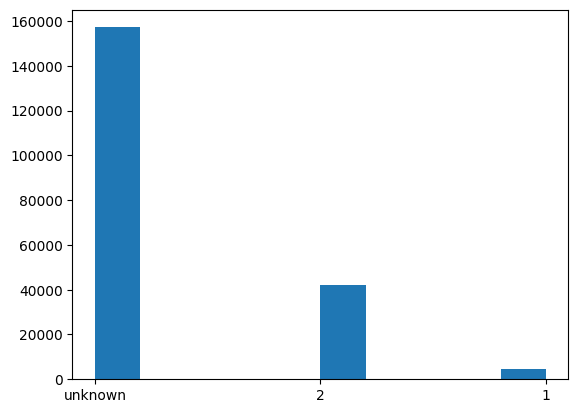

In [6]:
plt.hist(classes_data['class'])

In [7]:
classes_data['class']=classes_data['class'].map({'1':0,'2':1,'unknown':2})

In [8]:
classes_data.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,1
4,230460314,2


In [9]:
# merging class and features
class_features_merged_data=features_data.merge(classes_data,how="left",right_on="txId",left_on=0)
class_features_merged_data.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,230425980,2
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792,5530458,2
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792,232022460,2
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792,232438397,1
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117,230460314,2


In [10]:
class_features_merged_data=class_features_merged_data.sort_values(0)
class_features_merged_data.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
199861,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
31635,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,1
133793,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,1
2945,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
198375,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [11]:
class_features_merged_data=class_features_merged_data.reset_index(drop=True)
class_features_merged_data.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,1
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,1
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [12]:
nodes=class_features_merged_data[0].values
nodes

array([     1076,      2534,      3181, ..., 403234715, 403235564,
       403244581], dtype=int64)

In [13]:
mapped_nodes={}
for i,j in enumerate(nodes):
    mapped_nodes[j]=i
# mapped_nodes

In [14]:
edges=edges_data.copy()
edges['txId1']

0         230425980
1         232022460
2         230460314
3         230333930
4         232013274
            ...    
234350    158365409
234351    188708874
234352    157659064
234353     87414554
234354    158589452
Name: txId1, Length: 234355, dtype: int64

In [15]:
edges['txId1']=edges['txId1'].map(mapped_nodes)

In [16]:
edges['txId1']

0         138670
1         141325
2         139232
3         138150
4         141268
           ...  
234350    100863
234351    112040
234352    100420
234353     54833
234354    101159
Name: txId1, Length: 234355, dtype: int64

In [17]:
mapped_nodes[230425980]

138670

In [18]:
edges['txId2']=edges['txId2'].map(mapped_nodes)

In [19]:
edges['txId2']

0           4142
1         142201
2         139223
3         140289
4         141368
           ...  
234350    100525
234351    112041
234352    100419
234353     81951
234354    101163
Name: txId2, Length: 234355, dtype: int64

In [20]:
edges=edges.astype(int)
edges.txId2

0           4142
1         142201
2         139223
3         140289
4         141368
           ...  
234350    100525
234351    112041
234352    100419
234353     81951
234354    101163
Name: txId2, Length: 234355, dtype: int32

In [21]:
edges_tensor=torch.tensor(np.array(edges.values).T,dtype=torch.long).contiguous()
edges_tensor

tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [22]:
weights = torch.tensor([1]* edges_data.shape[1] , dtype=torch.double) 

In [23]:
labels=class_features_merged_data['class'].values
labels

array([2, 1, 1, ..., 2, 2, 2], dtype=int64)

In [24]:
# mapping txIds to corresponding indices, to pass node features to the model

node_features = class_features_merged_data.drop(['txId'], axis=1).copy()
# node_features[0] = node_features[0].map(map_id) # Convert transaction ID to node ID \
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
classified_index = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
unclassified_index = node_features['class'].loc[node_features['class']==2].index

illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# Drop unwanted columns, 0 = transID, 1=time period, class = labels
node_features = node_features.drop(columns=[0, 1, 'class'])

# Convert to tensor
node_features_tensor = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)# drop unused columns
node_features_tensor

unique= [2 1 0]


tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [26]:
train_idx, valid_idx = train_test_split(classified_index.values, test_size=0.15)


## Pytorch Geometric Model

In [27]:
from torch_geometric.data import Data
data_train = Data(x=node_features_tensor, edge_index=edges_tensor, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.double))
# Add in the train and valid idx
data_train.train_idx = train_idx
data_train.valid_idx = valid_idx
data_train.test_idx = unclassified_index

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GATConv

class GAT_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, config):
        super(GAT_Model, self).__init__()
        self.config = config
        
        # GAT convolution layers
        self.conv1 = GATConv(in_channels=input_dim, out_channels=hidden_dim, heads=config["heads"])
        self.conv2 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        self.conv3 = GATConv(in_channels=config['heads'] * hidden_dim, out_channels=hidden_dim, heads=config['heads'])
        
        # Linear, dropout, and activation layers
        self.aggregation = nn.Sequential(
            nn.Linear(in_features=hidden_dim * config['heads'], out_features=hidden_dim),
            nn.Dropout(p=config["dropout"]),
            nn.Linear(in_features=hidden_dim, out_features=output_dim)
        )
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.config['dropout'], training=self.training)
        
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        x = self.aggregation(x)
        x = torch.sigmoid(x)
        
        return x


In [29]:
class GnnTrainer(object):
  
  def __init__(self, model):
    self.model = model
    self.metric_manager = MetricManager(modes=["train", "val"])

  def train(self, data_train, optimizer, criterion, scheduler, args):
  
    self.data_train = data_train
    for epoch in range(args['epochs']):
        self.model.train()
        optimizer.zero_grad()
        out = self.model(data_train)

        out = out.reshape((data_train.x.shape[0]))
        loss = criterion(out[data_train.train_idx], data_train.y[data_train.train_idx])
        ## Metric calculations
        # train data
        target_labels = data_train.y.detach().cpu().numpy()[data_train.train_idx]
        pred_scores = out.detach().cpu().numpy()[data_train.train_idx]
        train_acc, train_f1,train_f1macro, train_aucroc, train_recall, train_precision, train_cm = self.metric_manager.store_metrics("train", pred_scores, target_labels)


        ## Training Step
        loss.backward()
        optimizer.step()

        # validation data
        self.model.eval()
        target_labels = data_train.y.detach().cpu().numpy()[data_train.valid_idx]
        pred_scores = out.detach().cpu().numpy()[data_train.valid_idx]
        val_acc, val_f1,val_f1macro, val_aucroc, val_recall, val_precision, val_cm = self.metric_manager.store_metrics("val", pred_scores, target_labels)

        if epoch%5 == 0:
          print("epoch: {} - loss: {:.4f} - accuracy train: {:.4f} -accuracy valid: {:.4f}  - val roc: {:.4f}  - val f1micro: {:.4f}".format(epoch, loss.item(), train_acc, val_acc, val_aucroc,val_f1))

  # To predict labels
  def predict(self, data=None, unclassified_only=True, threshold=0.5):
    # evaluate model:
    self.model.eval()
    if data is not None:
      self.data_train = data

    out = self.model(self.data_train)
    out = out.reshape((self.data_train.x.shape[0]))

    if unclassified_only:
      pred_scores = out.detach().cpu().numpy()[self.data_train.test_idx]
    else:
      pred_scores = out.detach().cpu().numpy()

    pred_labels = pred_scores > threshold

    return {"pred_scores":pred_scores, "pred_labels":pred_labels}

  # To save metrics
  def save_metrics(self, save_name, path="./save/"):
    file_to_store = open(path + save_name, "wb")
    pickle.dump(self.metric_manager, file_to_store)
    file_to_store.close()
  
  # To save model
  def save_model(self, save_name, path="./save/"):
    torch.save(self.model.state_dict(), path + save_name)

In [61]:
class MetricManager(object):
  def __init__(self, modes=["train", "val"]):

    self.output = {}

    for mode in modes:
      self.output[mode] = {}
      self.output[mode]["accuracy"] = []
      self.output[mode]["f1micro"] = []
      self.output[mode]["f1macro"] = []
      self.output[mode]["aucroc"] = []
      #new
      self.output[mode]["precision"] = []
      self.output[mode]["recall"] = []
      self.output[mode]["cm"] = []

  def store_metrics(self, mode, pred_scores, target_labels, threshold=0.5):

    # calculate metrics
    pred_labels = pred_scores > threshold
    accuracy = accuracy_score(target_labels, pred_labels)
    f1micro = f1_score(target_labels, pred_labels,average='micro')
    f1macro = f1_score(target_labels, pred_labels,average='macro')
    aucroc = roc_auc_score(target_labels, pred_scores)
    #new
    recall = recall_score(target_labels, pred_labels)
    precision = precision_score(target_labels, pred_labels)
    cm = confusion_matrix(target_labels, pred_labels)

    # Collect results
    self.output[mode]["accuracy"].append(accuracy)
    self.output[mode]["f1micro"].append(f1micro)
    self.output[mode]["f1macro"].append(f1macro)
    self.output[mode]["aucroc"].append(aucroc)
    #new
    self.output[mode]["recall"].append(recall)
    self.output[mode]["precision"].append(precision)
    self.output[mode]["cm"].append(cm)
    
    return accuracy, f1micro,f1macro, aucroc,recall,precision,cm
  
  # Get best results
  def get_best(self, metric, mode="val"):

    # Get best results index
    best_results = {}
    i = np.array(self.output[mode][metric]).argmax()

    # Output
    for m in self.output[mode].keys():
      best_results[m] = self.output[mode][m][i]
    
    return best_results

In [62]:
# Set training arguments, set prebuild=True to use builtin PyG models otherwise False
args={"epochs":100,
      'lr':0.01,
      'weight_decay':1e-5,
      'prebuild':True,
      'heads':2,
      'hidden_dim': 128, 
      'dropout': 0.5
      }

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [64]:
model = GAT_Model(data_train.num_node_features, args['hidden_dim'], 1, args)
model.double().to(device)

GAT_Model(
  (conv1): GATConv(165, 128, heads=2)
  (conv2): GATConv(256, 128, heads=2)
  (conv3): GATConv(256, 128, heads=2)
  (aggregation): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Dropout(p=0.5, inplace=False)
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [65]:
# Push data to GPU
data_train = data_train.to(device)

# Setup training settings
optimizer = torch.optim.Adam(model.parameters(), lr=args['lr'], weight_decay=args['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
criterion = torch.nn.BCELoss()

# Train
gnn_trainer_gat = GnnTrainer(model)
gnn_trainer_gat.train(data_train, optimizer, criterion, scheduler, args)

gnn_trainer_gat.save_metrics("GATprebuilt.results", path=FOLDERNAME + "/save_results/")
gnn_trainer_gat.save_model("GATprebuilt.pth", path=FOLDERNAME + "/save_results/")

epoch: 0 - loss: 0.7947 - accuracy train: 0.3378 -accuracy valid: 0.3341  - val roc: 0.4340  - val f1micro: 0.3341
epoch: 5 - loss: 0.2951 - accuracy train: 0.9023 -accuracy valid: 0.9029  - val roc: 0.8781  - val f1micro: 0.9029


KeyboardInterrupt: 